In [2]:
# IMPORT LIBRARIES
try:
    # PYSPARK
    from pyspark.sql import SparkSession
    from pyspark import SparkContext
    from pyspark.sql import SQLContext
    from pyspark.sql import DataFrame
    import pyspark.sql.types as tp
    import pyspark.sql.functions as F
    
    #Py Spark ML Libraries
    from pyspark.ml.classification import LogisticRegression
    from pyspark.ml.regression import LinearRegression
    from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
    from pyspark.ml import Pipeline
    from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
    
    # OTHER LIBRARIES
    import pandas as pd
    import numpy as np
    import glob
    from functools import reduce
    import seaborn as sns
    import matplotlib.pyplot as plt
    from urllib.request import urlopen
    import datetime
    from pathlib import Path
    
    print('[SUCCESS]')

    #CATCH ERROR IMPORTING A LIBRARY
except ImportError as ie:
    raise ImportError(f'[Error importing]: {ie}')

[SUCCESS]


In [3]:
'''
INITIALIZING SPARK SESSION
- NAME IS SET FOR SPARK SESSION WHEN RUNNING ON LOCAL HOST
'''
spark = SparkSession.builder.master('local').config("spark.executor.memory", "1g").config("spark.driver.memory", "2g").appName('UsedCar_Project').getOrCreate()
print('[SUCCESSFULLY RUNNING SPARK SESSION]')

[SUCCESSFULLY RUNNING SPARK SESSION]


In [4]:
def load_data():
    '''
    car_prices.csv is uploaded to a google bucket for public use. Since file is too large to push to GitHub for others to use from repo
    this function will load the data from the google bucket.
    
    You can run this function each time and it will not download a new dataset each time since the first time you run it, it will download locally to your directory.
    --- unless you delete it each time
    
    Function will check to make sure file is in the directory
    - if it is, load it to a spark dataframe
    - if it is not, download it, then load it to a spark dataframe
    
    SCHEMA:
    - Created a schema to make sure the data types for the file being read is kept
    
    
    Drop Randome Values in state columns
    
    
    WARNING: TO USE THIS FUNCTION, YOU HAVE TO BE RUNNING JUPYTER NOTEBOOK ON A LINUX SERVER (USE DOCKER)
    
    NOTES:
    option("header",True).option("inferSchema", True)
    '''
    
    # CHECKS TO SEE IF FILE EXIST
    path = Path('car_prices.csv') 
    
    # IF FILE DOES NOT EXIST
    if not path.is_file():
        !wget https://storage.googleapis.com/iamangelsh-public-datasets/car_prices.csv 
    
    
    
    # CREATE SCHEMA TO KEEP DATA TYPES
    schema = tp.StructType([tp.StructField('year', tp.IntegerType(), True),
                           tp.StructField('make', tp.StringType(), True),
                           tp.StructField('model', tp.StringType(), True),
                           tp.StructField('trim', tp.StringType(), True),
                           tp.StructField('body', tp.StringType(), True),
                           tp.StructField('transmission', tp.StringType(), True),
                           tp.StructField('vin', tp.StringType(), True),
                           tp.StructField('state', tp.StringType(), True),
                           tp.StructField('condition', tp.DoubleType(), True),
                           tp.StructField('odometer', tp.DoubleType(), True),
                           tp.StructField('color', tp.StringType(), True),
                           tp.StructField('interior', tp.StringType(), True),
                           tp.StructField('seller', tp.StringType(), True),
                           tp.StructField('mmr', tp.IntegerType(), True),
                           tp.StructField('sellingprice', tp.IntegerType(), True),
                           tp.StructField('saledate', tp.StringType(), True)])
    
    
    # LOAD IN DATA WITH SCHEMA
    df = spark.read.csv("car_prices.csv", header = True, sep=",", schema=schema)
    
    # FILTER OUT VIN NUMBERS FROM STATE COLUMN
    df = df.where(F.length(F.col("state")) <= 2)
    
    # DROP ROWS THAT CONTAIN NULL VALUES
    df = df.na.drop('any')
    
    # CREATE THRESHOLD FOR CONDITION COLUMN
    df = df.withColumn(
        'condition', 
        F.when(df.condition > 3.75, 'Great'
        ).when((df.condition >= 2) & (df.condition <= 3.75), 'Average'
        ).when(df.condition < 2, 'Bad'))
    
    # DROP COLUMNS THAT WON'T BE USED
    cols = ('trim', 'vin', 'interior', 'seller')
    df = df.drop(*cols)
    
    
    # USE MM DD YYYY FOR SALEDATE COLUMN
    df = df.withColumn(
        'saledate', F.substring('saledate', 5,11)
        ).withColumn(
        'saledate_year', F.substring('saledate', 7,5)
        ).withColumn(
        'saledate_month', F.substring('saledate', 1,3))
    
    df = df.withColumn(
        'saledate_year', F.col('saledate_year').cast(tp.IntegerType())
        )
    
    # RETURN NEW DATAFRAME
    return df


# LOAD THE DATA
df = load_data()

# SHOW DATA
df.show(5)

# SHOW NUMBER OF COLUMNS AND ROWS
print(f'Number of columns: {len(df.columns)} \nNumber of Rows: {df.count()}')
print()

# SHOW SCHEMA - DATATYPES
df.printSchema()

+----+-----+-------------------+-----+------------+-----+---------+--------+-----+-----+------------+-----------+-------------+--------------+
|year| make|              model| body|transmission|state|condition|odometer|color|  mmr|sellingprice|   saledate|saledate_year|saledate_month|
+----+-----+-------------------+-----+------------+-----+---------+--------+-----+-----+------------+-----------+-------------+--------------+
|2015|  Kia|            Sorento|  SUV|   automatic|   ca|    Great| 16639.0|white|20500|       21500|Dec 16 2014|         2014|           Dec|
|2015|  Kia|            Sorento|  SUV|   automatic|   ca|    Great|  9393.0|white|20800|       21500|Dec 16 2014|         2014|           Dec|
|2014|  BMW|           3 Series|Sedan|   automatic|   ca|    Great|  1331.0| gray|31900|       30000|Jan 15 2015|         2015|           Jan|
|2015|Volvo|                S60|Sedan|   automatic|   ca|    Great| 14282.0|white|27500|       27750|Jan 29 2015|         2015|           Jan|

In [12]:
# EDA Analysis.
sns.set(color_codes=True)
%matplotlib inline
df.head()
pandas_df = df.toPandas()

In [26]:
# Displays the correlation between every possible pair of attributes
pandas_df.corr()

,year,odometer,mmr,sellingprice,saledate_year
year,1.000000,-0.773104,0.588605,0.578918,0.044563
odometer,-0.773104,1.000000,-0.582648,-0.577385,-0.026781
mmr,0.588605,-0.582648,1.000000,0.983492,0.027441
sellingprice,0.578918,-0.577385,0.983492,1.000000,0.029529
saledate_year,0.044563,-0.026781,0.027441,0.029529,1.000000


<AxesSubplot:>

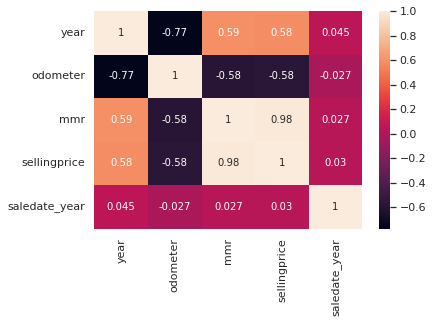

In [28]:
# Uses a heat map to represenet the same correlations
sns.heatmap(pandas_df.corr(), annot=True)

<AxesSubplot:xlabel='sellingprice', ylabel='Count'>

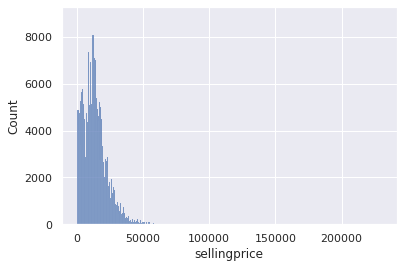

In [14]:
# Plot selling price information
sns.histplot(pandas_df.sellingprice)

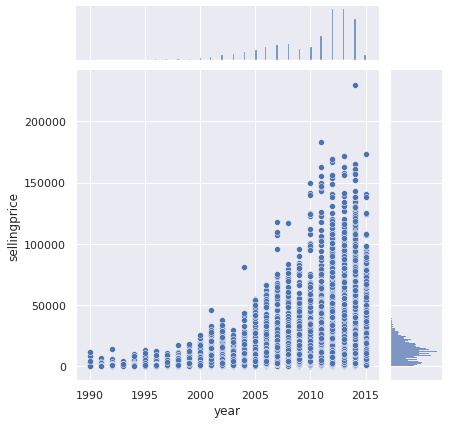

In [16]:
# Year and selling price have a good correlation
# Plot a graph using those 2 features.
sns.jointplot(data = pandas_df, x = 'year', y = 'sellingprice')

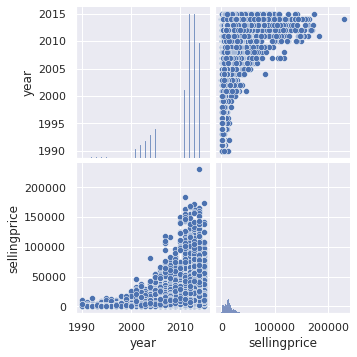

In [21]:
# Pairplot using year and selling price
sns.pairplot(pandas_df[['year','sellingprice']])

<AxesSubplot:xlabel='year', ylabel='sellingprice'>

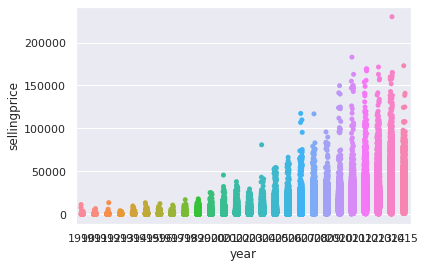

In [23]:
sns.stripplot(data = pandas_df, x = 'year', y = 'sellingprice', jitter=True)

<AxesSubplot:xlabel='year', ylabel='sellingprice'>

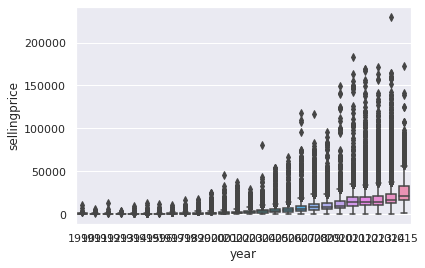

In [24]:
# Using a blox plot to see if there are any outliers, we can see at least one.
sns.boxplot(data = pandas_df, x = 'year', y = 'sellingprice')

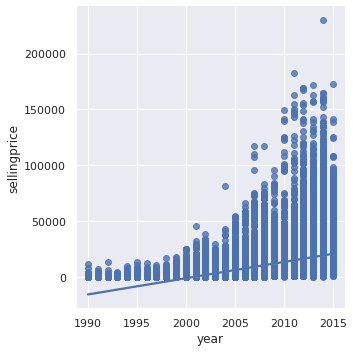

In [25]:
# Plot a linear regression graph
sns.lmplot(y='sellingprice',x='year', data=pandas_df)